In [1]:
import numpy as np

def gaussian_weight(x, x_center, sd):
    return np.exp(-((x - x_center) / sd) ** 2)

def rules_numerator(y_rule, z_rule):
    return np.sum(y_rule * z_rule)

def weights_denominator(z_rule):
    return np.sum(z_rule)

def normalized_output(numer, denom):
    return numer / denom

def half_mse(f, y):
    return ((f - y) ** 2) / 2

def update_consequent(y_rule, lr, f, y, denom, z_rule):
    return y_rule - lr * (f - y) * z_rule / denom

def update_center(x_center, lr, f, y, denom, z_rule, y_rule, x, sd):
    return x_center - lr * ((f - y) / denom) * (y_rule - f) * z_rule * 2 * (x - x_center) / (sd ** 2)

def update_spread(sd, lr, f, y, denom, z_rule, y_rule, x, x_center):
    return sd - lr * ((f - y) / denom) * (y_rule - f) * z_rule * 2 * ((x - x_center) ** 2) / (sd ** 3)

def true_g(u):
    return 0.6 * np.sin(np.pi * u) + 0.3 * np.sin(np.pi * 3 * u) + 0.1 * np.sin(np.pi * 5 * u)


In [2]:
rng = np.random.default_rng(42)

x = np.linspace(0.0, 2.0, 1000)           # inputs
y_true = true_g(x)                         # targets

M = 15                                     # number of rules
centers = np.linspace(0.0, 2.0, M)         # (M,)
spreads = np.full(M, 0.3)                  # (M,)
consequents = rng.uniform(-1, 1, size=M)   # (M,)

lr_y = 1e-2
lr_c = 1e-2
lr_s = 1e-2
eps  = 1e-8

error_history = []

# --- Online training loop (same behavior, safer numerics) ---
for epoch in range(100):
    err_sum = 0.0

    # shuffle each epoch (cosmetic improvement)
    order = rng.permutation(len(x))
    for idx in order:
        u = x[idx]
        y = y_true[idx]

        z = gaussian_weight(u, centers, spreads)        # (M,)
        numer = rules_numerator(consequents, z)         # scalar
        denom = weights_denominator(z) + eps            # scalar (safe)
        f = normalized_output(numer, denom)             # scalar

        err_sum += half_mse(f, y)

        # parameter updates (same formulas; renamed helpers)
        consequents = update_consequent(consequents, lr_y, f, y, denom, z)
        centers     = update_center(centers,     lr_c, f, y, denom, z, consequents, u, spreads)
        spreads     = update_spread(spreads,     lr_s, f, y, denom, z, consequents, u, centers)

        # keep spreads positive to avoid NaNs
        spreads = np.maximum(spreads, 1e-3)

    error_history.append(err_sum / len(x))

print(error_history)

[np.float64(0.030745997106033318), np.float64(0.004268309779185179), np.float64(0.0023428500235775323), np.float64(0.0019253666701061066), np.float64(0.01297720307873919), np.float64(0.00762108848071063), np.float64(0.0041613133313109715), np.float64(0.0028903757761232973), np.float64(0.0022500545045665886), np.float64(0.001878455249146599), np.float64(0.0016392198103368605), np.float64(0.0014562713670099132), np.float64(0.0013164993221522069), np.float64(0.0012088684865231812), np.float64(0.0011145243803586922), np.float64(0.0010423981537577526), np.float64(0.0009800779798008114), np.float64(0.0009262320512411509), np.float64(0.000877236452575211), np.float64(0.0008388167634107793), np.float64(0.0008006190275132449), np.float64(0.0007686833452475827), np.float64(0.0007363643088364853), np.float64(0.0007076393568222884), np.float64(0.0006803795930253078), np.float64(0.0006519209893249865), np.float64(0.0006165912581373546), np.float64(0.0005889312369354502), np.float64(0.00056165912059

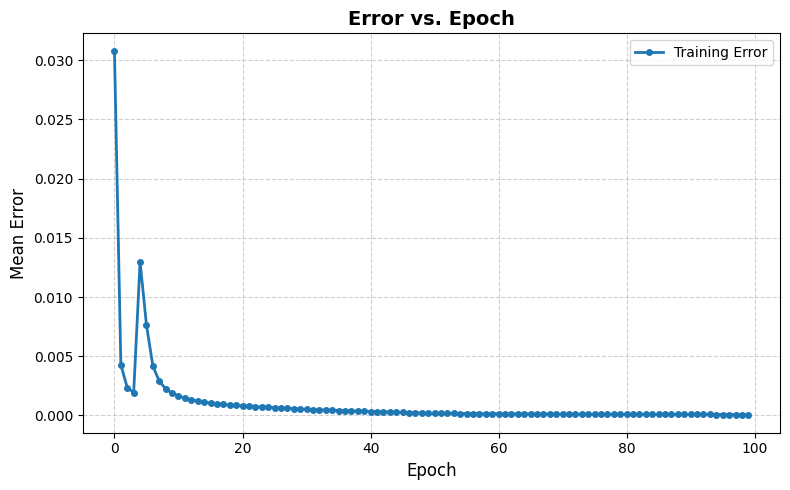

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(error_history, color='tab:blue', linewidth=2, marker='o', markersize=4, label='Training Error')
plt.title("Error vs. Epoch", fontsize=14, fontweight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Mean Error", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=10, loc='upper right')
plt.tight_layout()
plt.show()


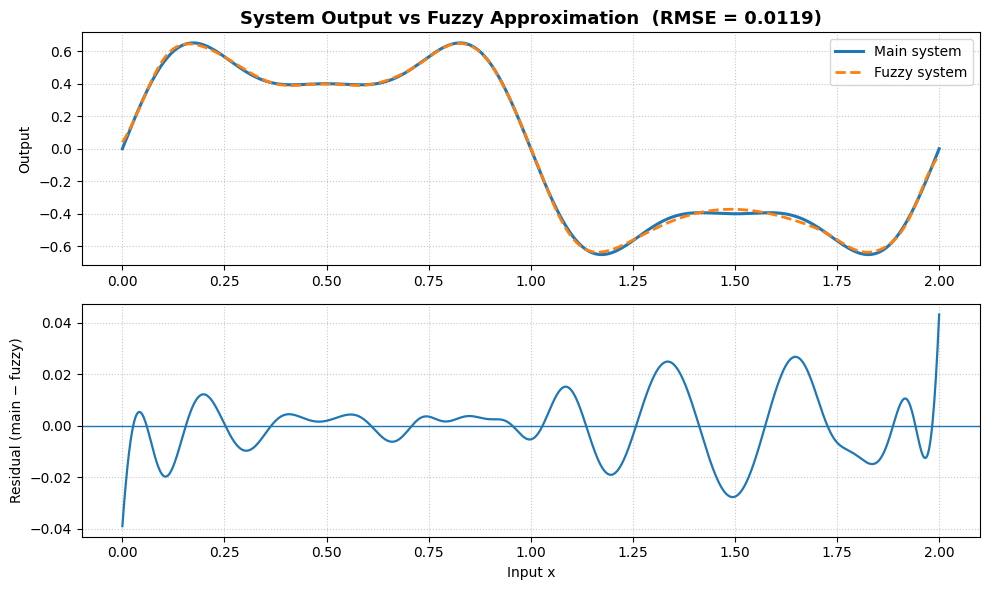

In [4]:
# --- Vectorized prediction using the renamed variables/helpers ---
eps = 1e-8
W = np.exp(-((x[:, None] - centers[None, :]) / spreads[None, :])**2)   # [N x M]
num = W @ consequents                                                  # [N]
den = W.sum(axis=1) + eps                                              # [N]
y_pred = num / den                                                     # [N]
rmse = np.sqrt(np.mean((y_pred - y_true)**2))

# --- Pretty plots: overlay + residuals ---
plt.figure(figsize=(10, 6))

# Top: main vs fuzzy
ax1 = plt.subplot(2, 1, 1)
ax1.plot(x, y_true, linewidth=2.2, label="Main system")
ax1.plot(x, y_pred, linewidth=2.0, linestyle='--', label="Fuzzy system")
ax1.set_title(f"System Output vs Fuzzy Approximation  (RMSE = {rmse:.4f})", fontsize=13, fontweight='bold')
ax1.set_ylabel("Output")
ax1.grid(True, linestyle=':', alpha=0.7)
ax1.legend(loc="best")

# Bottom: residuals
ax2 = plt.subplot(2, 1, 2, sharex=ax1)
ax2.plot(x, y_true - y_pred, linewidth=1.6)
ax2.axhline(0.0, linewidth=1.0)
ax2.set_xlabel("Input x")
ax2.set_ylabel("Residual (main − fuzzy)")
ax2.grid(True, linestyle=':', alpha=0.7)

plt.tight_layout()
plt.show()